In [1]:
import numpy as np 
import pandas as pd
import string
from tqdm import tqdm
import math,nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import  hstack
# from handFeaturesV6 import hand_features, clean, get_tokenized_lemmas, remove_stopwords
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, concatenate,Flatten,LSTM, Embedding, Input,Dropout
from keras.models import Model
# from WF_gw2v_embedding import gw2v_sentence_embeddings
from keras.callbacks import ModelCheckpoint
import os
import re
import nltk
import string
import numpy as np
from sklearn import feature_extraction
from tqdm import tqdm


_wnl = nltk.WordNetLemmatizer()

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
Using TensorFlow backend.


In [2]:
def normalize_word(w):
    return _wnl.lemmatize(w).lower()


def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]


def clean(text):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation),''))
    return " ".join(re.findall(r'\w+', text, flags=re.UNICODE)).lower()


def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]
def join_tok(text):
    return " ".join(text).lower()

In [3]:
def process(texts):
    lst=[]
    for text in tqdm(texts):
        clean_text= clean(text)
        tok_text= get_tokenized_lemmas(clean_text)
        remov_stp= remove_stopwords(tok_text)
        lst.append(join_tok(remov_stp))
    return lst

In [4]:
data= pd.read_csv('../input/aossie-click-bait-dataset/clickBait_Data.csv')

In [5]:
data.head()

,index,id,titles,clickbait
0,6574,6575,25 Things We Learned From Julia Louis-Dreyfus ...,1
1,39655,39656,John Brennan: Trump's 'Nazi Germany' tweet to ...,0
2,44513,44514,"TruthRevolt.org: ISIS Stands For ""Israeli Secr...",0
3,44205,44206,Peak Millennial? Cities Cant Assume a Continue...,0
4,11106,11107,This Entire City Is Made Out Of Ice And It Wil...,1


In [6]:
titles=  process(data['titles'])

100%|██████████| 59172/59172 [00:13<00:00, 4258.43it/s]


In [7]:
tok= Tokenizer()
tok.fit_on_texts(titles)

In [8]:
vocab_size= len(tok.word_index)+1
embed_len= 300
embedd_matrix= np.zeros((vocab_size,embed_len))

In [9]:
titles=tok.texts_to_sequences(titles)
titles= pad_sequences(titles,maxlen=40,padding='post')

In [10]:
fileName= '../input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin.gz'
G_w2v = KeyedVectors.load_word2vec_format(fileName, binary=True)

In [11]:
for word, idx in tok.word_index.items():
    if word in G_w2v:
            embedd_matrix[idx]=G_w2v[word][0:embed_len]
        

In [12]:
labels= data['clickbait'].tolist()

In [13]:
max_len=40

In [14]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( titles, labels, test_size=0.3, random_state=42, shuffle= True)

In [15]:
print("Training Data size: ", X_train.shape[0])
print("Testing data size: ", X_test.shape[0])

Training Data size:  41420
Testing data size:  17752


In [16]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout,Embedding,LSTM

In [17]:
model= Sequential()
model.add(Embedding(vocab_size,embed_len,weights= [embedd_matrix],input_length=max_len))
model.add(LSTM(100,return_sequences=True))
model.add(Dense(50,activation='relu'))
model.add(Flatten())
model.add(Dense(460,activation='relu'))
model.add(Dense(180,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(1,activation='sigmoid'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
filepath=r"ClickBait-2_lstm_gw2v_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [19]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 300)           7853700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 100)           160400    
_________________________________________________________________
dense_1 (Dense)              (None, 40, 50)            5050      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 460)               920460    
_________________________________________________________________
dense_3 (Dense)              (None, 180)               82980     
_________________________________________________________________
dropout_1 (Dropout)          (None, 180)               0         
__________

In [20]:
model.fit(X_train,y_train,epochs=30,batch_size=3,verbose=1,validation_split=0.02,callbacks=callbacks_list, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 40591 samples, validate on 829 samples
Epoch 1/30
17418/40591 [===========>..................] - ETA: 7:29 - loss: 0.5126 - acc: 0.7461

In [21]:
prediction= model.predict(X_test)

In [22]:
YClass= np.zeros((len(prediction)))

In [23]:
for i in range(len(prediction)):
    if prediction[i][0]>=0.5:
        YClass[i]=1
    else:
        YClass[i]=0

In [24]:
from sklearn.metrics import confusion_matrix


In [25]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
#matrix1 = confusion_matrix(test_labels, prediction)



In [26]:
matrix1 = confusion_matrix(y_test, YClass)

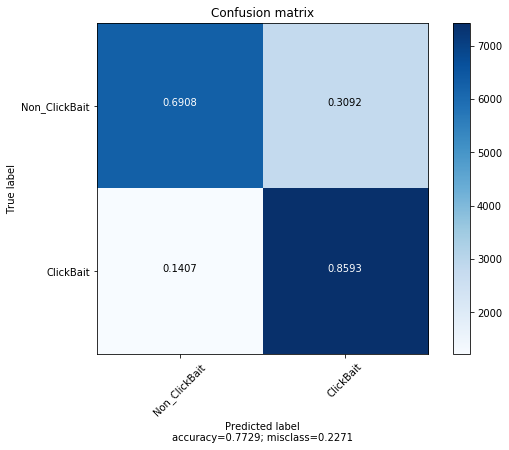

In [27]:
plot_confusion_matrix(cm=matrix1,target_names=['Non_ClickBait', 'ClickBait'])